# Hardware Optimization of Quantum Violations of the Bilocal Inquality

This notebook aggregates and plots data from non-bilocality optimizations on quantum hardware. Data is analyzed for the following data collection scripts:
* `./script/ibm_casablanca_simple_bilocal_opt_parameter_shift.py`
* `./script/ibm_casablanca_simple_bilocal_opt_natural_gradient.py`

In [34]:
from context import QNetOptimizer as QNopt
from context import utilities
from context import network_ansatzes
import matplotlib.pyplot as plt
from pennylane import numpy as np

The data from all of our hardware optimizations is imported from file. 

In [35]:
data_path_nat_grad = "../../script/data/ibm_casablanca_simple_bilocal_opt_natural_gradient/"
data_path_param_shift = "../../script/data/ibm_casablanca_simple_bilocal_opt_parameter_shift/"

data_files_nat_grad = utilities.get_data_files(data_path_nat_grad, r".*")
nat_grad_opt_dicts = [QNopt.read_optimization_json(file) for file in data_files_nat_grad]
print("num natural gradient optimizations : ", len(data_files_nat_grad))

data_files_param_shift = utilities.get_data_files(data_path_param_shift, r".*")
param_shift_opt_dicts = [QNopt.read_optimization_json(file) for file in data_files_param_shift]
print("num parameter shift optimizations : ", len(data_files_param_shift))

num natural gradient optimizations :  5
num parameter shift optimizations :  5


We compute the mean and standard error across for each iteration across all hardware runs.

In [36]:
def scores_mean_stderr(opt_dicts, num_samples):
    scores_array = np.array([opt_dict["scores"][0:num_samples] for opt_dict in opt_dicts])    
    settings_array = [opt_dict["settings_history"][0:num_samples] for opt_dict in opt_dicts]
    theoretical_max_array = np.array([opt_dict["theoretical_score"] for opt_dict in opt_dicts])
    mean_theoretical_score = np.mean(theoretical_max_array)

    scores_mean = np.mean(scores_array, axis=0)   
    scores_stderr = np.std(scores_array, axis=0, ddof=1) / np.sqrt(scores_array.shape[1])
    scores_max = np.max(scores_array, axis=0)
    max_ids = np.argmax(scores_array, axis=0)
    max_settings = [
        settings_array[max_ids[i]][i] for i in range(num_samples) 
    ]

    return (scores_max, scores_mean, scores_stderr, max_settings, mean_theoretical_score)

In [37]:
prep_nodes = [
    QNopt.PrepareNode(1, [0, 1], QNopt.ghz_state, 0),
    QNopt.PrepareNode(1, [2, 3], QNopt.ghz_state, 0),
]
meas_nodes = [
    QNopt.MeasureNode(2, 2, [0], QNopt.local_RY, 1),
    QNopt.MeasureNode(2, 2, [1, 2], QNopt.local_RY, 2),
    QNopt.MeasureNode(2, 2, [3], QNopt.local_RY, 1),
]

bilocal_ansatz = QNopt.NetworkAnsatz(prep_nodes, meas_nodes)
bilocal_cost = QNopt.nlocal_chain_cost_22(bilocal_ansatz)

## Visualization

Note that natural gradient file `2022-01-23T14-21-25Z.json` needs an additional step

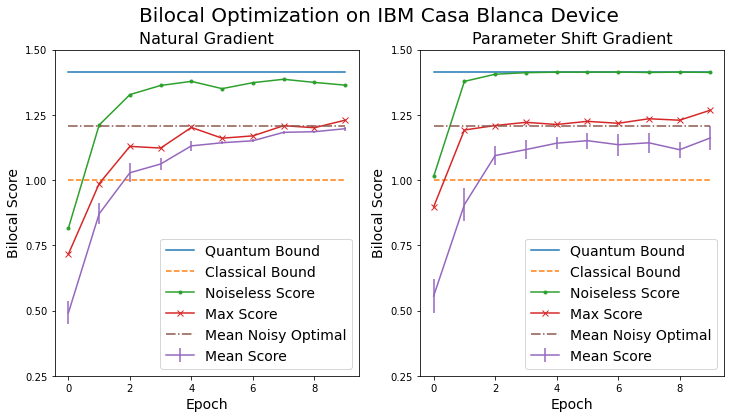

In [39]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
yticks = [0.25,0.5,0.75,1,1.25,1.5]

num_samples = 10 # should be 11

(
    nat_grad_max,
    nat_grad_mean,
    nat_grad_err,
    nat_grad_max_settings,
    nat_grad_mean_theory_score,
) = scores_mean_stderr(nat_grad_opt_dicts, num_samples)

nat_grad_ideal_scores = [
    -(bilocal_cost(nat_grad_max_settings[i])) for i in range(num_samples)
]

(
    param_shift_max,
    param_shift_mean,
    param_shift_err,
    param_shift_max_settings,
    param_shift_mean_theory_score,
) = scores_mean_stderr(param_shift_opt_dicts, num_samples)
param_shift_ideal_scores = [
    -(bilocal_cost(param_shift_max_settings[i])) for i in range(num_samples)
]

avg_bilocal_score = (nat_grad_mean_theory_score + param_shift_mean_theory_score)/2

ax1.plot(range(num_samples), [np.sqrt(2)]*num_samples, "-", label="Quantum Bound")
ax1.plot(range(num_samples), [1]*num_samples, "--", label="Classical Bound")
ax1.plot(range(num_samples), nat_grad_ideal_scores, marker=".", label="Noiseless Score")
ax1.plot(range(num_samples), nat_grad_max, marker="x" , label="Max Score")
ax1.errorbar(range(num_samples), nat_grad_mean, nat_grad_err, label="Mean Score")
ax1.plot(range(num_samples), [avg_bilocal_score]*num_samples, "-.", label="Mean Noisy Optimal")

ax1.set_title("Natural Gradient", size=16)
ax1.set_xlabel("Epoch", size=14)
ax1.set_ylabel("Bilocal Score", size=14)
ax1.set_yticks(yticks)
ax1.legend(loc="lower right", fontsize=14)

ax2.plot(range(num_samples), [np.sqrt(2)]*num_samples, "-", label="Quantum Bound")
ax2.plot(range(num_samples), [1]*num_samples, "--", label="Classical Bound")
ax2.plot(range(num_samples), param_shift_ideal_scores, marker=".", label="Noiseless Score")
ax2.plot(range(num_samples), param_shift_max, marker="x" , label="Max Score")
ax2.errorbar(range(num_samples), param_shift_mean, param_shift_err, label="Mean Score")
ax2.plot(range(num_samples), [avg_bilocal_score]*num_samples, "-.", label="Mean Noisy Optimal")

ax2.set_title("Parameter Shift Gradient", size=16)
ax2.set_xlabel("Epoch", size=14)
ax2.set_ylabel("Bilocal Score", size=14)
ax2.set_yticks(yticks)
ax2.legend(loc="lower right", fontsize=14)

fig.suptitle("Bilocal Optimization on IBM Casa Blanca Device\n", size=20)
plt.show()